<a href="https://colab.research.google.com/github/konkuad/my-files/blob/master/LRP_on_13_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
data = np.load("/content/drive/My Drive/bonn/data.npy")
label = np.load("/content/drive/My Drive/bonn/label.npy")
from tensorflow.python.keras.models import load_model
model = load_model("/content/drive/My Drive/bonn/13_layer_cnn.h5")

In [ ]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Conv1D,MaxPooling1D
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
extractor = Model(inputs=model.inputs,outputs=[layer.output for layer in model.layers])

In [ ]:
probability_model = tf.keras.Sequential([model])
predictions = probability_model.predict(data)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 4097, 4)        28        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 4097, 4)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 2049, 4)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2049, 4)        84        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 2049, 4)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1025, 4)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1025, 10)       1

In [ ]:
wb = model.get_weights()

In [ ]:
weights = []
biases = []
for i in range(8):
  weights.append(wb[2*i])
  biases.append(wb[2*i+1])

In [ ]:
def pos_con(x,gamma):
  return(x+np.maximum(x,0)*gamma)

In [ ]:
b=biases[4]
np.repeat(np.repeat(b.reshape(1,1,1,b.shape[0]),300,axis=0),257,axis=2).shape

(300, 1, 257, 15)

In [ ]:
weights[4].mean()

-0.0024010742

In [ ]:
def incr(x,y):
  return(x+0.25*y.mean())
gamma = 0.25
A_all = []
for i in range(len(extractor(data))):
  A_all.append(extractor(data)[i].numpy())
w = weights[7]
w = np.array([pos_con(x,gamma) for x in w])
b = biases[7]   
R = [None]*18+[extractor(data)[18].numpy()-np.repeat(b.reshape(1,b.shape[0]),300,axis=0)] 
AR = np.multiply(A_all[18],R[18])
wAR = AR.dot(np.transpose(w))
wA = A_all[18].dot(np.transpose(w))
###################################
w = weights[6]
w = np.array([pos_con(x,gamma) for x in w])
b = biases[6]    
R[17] = np.divide(wAR,wA)-np.repeat(b.reshape(1,b.shape[0]),300,axis=0)
AR = np.multiply(A_all[17],R[17])
wAR = AR.dot(np.transpose(w))
wA = A_all[17].dot(np.transpose(w))
###################################
w = weights[5]
w = np.array([pos_con(x,gamma) for x in w])
b = biases[5] 
R[16] = np.divide(wAR,wA)-np.repeat(b.reshape(1,b.shape[0]),300,axis=0) 
AR = np.multiply(A_all[16],R[16])
wAR = AR.dot(np.transpose(w))
wA = A_all[16].dot(np.transpose(w))
R[15] = np.divide(wAR,wA)
R[14] = R[15].reshape([300,1,129,15])
###################################
R[13] = np.repeat(R[14],2,axis=2)[:,:,0:257,:]
w = np.swapaxes(weights[4],2,3)
w = np.array([pos_con(x,gamma) for x in w])
b = biases[4] 
R[12] = R[13]-np.repeat(np.repeat(b.reshape(1,1,1,b.shape[0]),300,axis=0),257,axis=2)
A = np.flip(A_all[12],axis=2)
AR = np.flip(np.multiply(A_all[12],R[12]),axis=2)
conv_lrp = Sequential()
conv_lrp.add(Conv2D(10,(4,1),padding="same",strides=1,use_bias=False,input_shape=(1,257,15)))
conv_lrp.layers[0].set_weights([w])
wAR = np.flip(conv_lrp.predict(AR),axis=2)
wA = np.flip(conv_lrp.predict(A),axis=2)
wA = np.array([incr(x,wA) for x in wA])
R[11] = np.divide(wAR,wA)
###################################
R[10] = np.repeat(R[11],2,axis=2)[:,:,0:513,:]
w = np.swapaxes(weights[3],2,3)
w = np.array([pos_con(x,gamma) for x in w])
b = biases[3] 
R[9] = R[10]-np.repeat(np.repeat(b.reshape(1,1,1,b.shape[0]),300,axis=0),513,axis=2)
A = np.flip(A_all[9],axis=2)
AR = np.flip(np.multiply(A_all[9],R[9]),axis=2)
conv_lrp = Sequential()
conv_lrp.add(Conv2D(10,(4,1),padding="same",strides=1,use_bias=False,input_shape=(1,513,10)))
conv_lrp.layers[0].set_weights([w])
wAR = np.flip(conv_lrp.predict(AR),axis=2)
wA = np.flip(conv_lrp.predict(A),axis=2)
wA = np.array([incr(x,wA) for x in wA])
R[8] = np.divide(wAR,wA)
###################################
R[7] = np.repeat(R[8],2,axis=2)[:,:,0:1025,:]
w = np.swapaxes(weights[2],2,3)
w = np.array([pos_con(x,gamma) for x in w])
b = biases[2] 
R[6] = R[7]-np.repeat(np.repeat(b.reshape(1,1,1,b.shape[0]),300,axis=0),1025,axis=2)
A = np.flip(A_all[6],axis=2)
AR = np.flip(np.multiply(A_all[6],R[6]),axis=2)
conv_lrp = Sequential()
conv_lrp.add(Conv2D(4,(4,1),padding="same",strides=1,use_bias=False,input_shape=(1,1025,10)))
conv_lrp.layers[0].set_weights([w])
wAR = np.flip(conv_lrp.predict(AR),axis=2)
wA = np.flip(conv_lrp.predict(A),axis=2)
wA = np.array([incr(x,wA) for x in wA])
R[5] = np.divide(wAR,wA)
###################################
R[4] = np.repeat(R[5],2,axis=2)[:,:,0:2049,:]
w = np.swapaxes(weights[1],2,3)
w = np.array([pos_con(x,gamma) for x in w])
b = biases[1] 
R[3] = R[4]-np.repeat(np.repeat(b.reshape(1,1,1,b.shape[0]),300,axis=0),2049,axis=2)
A = np.flip(A_all[3],axis=2)
AR = np.flip(np.multiply(A_all[3],R[3]),axis=2)
conv_lrp = Sequential()
conv_lrp.add(Conv2D(4,(5,1),padding="same",strides=1,use_bias=False,input_shape=(1,2049,4)))
conv_lrp.layers[0].set_weights([w])
wAR = np.flip(conv_lrp.predict(AR),axis=2)
wA = np.flip(conv_lrp.predict(A),axis=2)
wA = np.array([incr(x,wA) for x in wA])
R[2] = np.divide(wAR,wA)
###################################
R[1] = np.repeat(R[2],2,axis=2)[:,:,0:4097,:]
w = np.swapaxes(weights[0],2,3)
w = np.array([pos_con(x,gamma) for x in w])
w = np.array([x**2 for x in w])
b = biases[0]
R[0] = R[1]-np.repeat(np.repeat(b.reshape(1,1,1,b.shape[0]),300,axis=0),4097,axis=2)
conv_lrp = Sequential()
conv_lrp.add(Conv2D(1,(6,1),padding="same",strides=1,use_bias=False,input_shape=(1,4097,4)))
conv_lrp.layers[0].set_weights([w])
Rwsq = np.flip(conv_lrp.predict(np.flip(R[0],axis=2)),axis=2)
wsq = np.flip(conv_lrp.predict(np.ones(R[0].shape)),axis=2)
LRP = np.divide(Rwsq,wsq)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


<function matplotlib.pyplot.show>

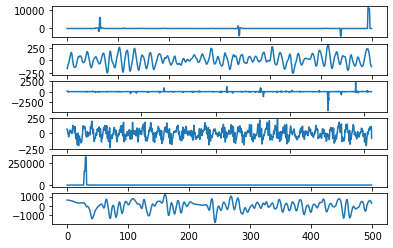

In [ ]:
plt.subplot(6,1,1)
plt.plot(LRP.reshape([300,4097,1])[10,1000:1600])
plt.show
plt.subplot(6,1,2)
plt.plot(data.reshape([300,4097,1])[10,1000:1600])
plt.show
plt.subplot(6,1,3)
plt.plot(LRP.reshape([300,4097,1])[150])
plt.subplot(6,1,4)
plt.plot(data.reshape([300,4097,1])[150])
plt.subplot(6,1,5)
plt.plot(LRP.reshape([300,4097,1])[200,3500:4000])
plt.subplot(6,1,6)
plt.plot(data.reshape([300,4097,1])[200,3500:4000])
plt.show

In [ ]:
weights[4].shape

(4, 1, 10, 15)